In [30]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import keras.datasets as kds
import keras.backend as K

# Loading MNIST data

In [31]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

# Function for merging label and input:

In [32]:
def edit_data(x, y, method="edit"):
    is_batch = x.ndim == 3
    if method == "edit":
        if is_batch:
            x[:, 0, :10] = 0.0
            for i in range(x.shape[0]):
                x[i, 0, y[i]] = 1.0
        else:
            x[0, :10] = 0.0
            x[0, y] = 1.0

# Function for creating a label for negative data:

In [33]:
def random_label(y):
    if type(y) != np.ndarray:
        label = list(range(10))
        del label[y]
        return np.random.choice(label)
    else:
        label = np.copy(y)
        for i in range(y.shape[0]):
            label[i] = random_label(y[i])
        return label

# Constructing positive and negative data:

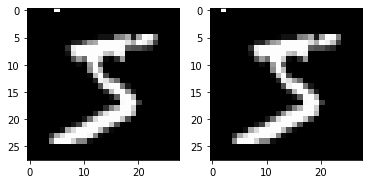

In [34]:
pos = np.copy(x_train)
neg = np.copy(x_train)
edit_data(pos, y_train)
edit_data(neg, random_label(y_train))
_, ax = plt.subplots(1, 2)
ax[0].imshow(pos[0], cmap="gray")
ax[1].imshow(neg[0], cmap="gray")
plt.show()

# Loss function:

'y_true' can be 1 and -1. 
-1 for positive data and 1 for negative data.
by this method we maximize goodness for positive data (-g+threshold) and minimize goodness for negative data (g-thhreshold)

In [35]:
from numpy.ma.core import append
def myLoss_with_threshold(threshold):
    def myLoss(y_true, y_pred):
        g = K.pow(y_pred, 2)
        g = K.mean(g, axis=1)
        g = g - threshold
        g = g * y_true
        loss = K.log(1 + K.exp(g))
        loss = K.mean(loss)
        return loss
    return myLoss

In [36]:
pos = pos.reshape(pos.shape[0], -1)
neg = neg.reshape(neg.shape[0], -1)
pos.shape, neg.shape

((60000, 784), (60000, 784))

In [37]:
def normalize_(x_):
    return x_ / (tf.norm(x_, ord=2, axis=1, keepdims=True) + 1e-4)

# Constructing Neural network:
In order to implement forward-forward correctly, we have to set an optimizer for each layer


In [38]:

layer1 = keras.Sequential([
    keras.layers.Dense(500, activation="relu", input_shape=[784])
])
layer2 = keras.Sequential([
    keras.layers.Dense(500, activation="relu", input_shape=[500])
])

In [39]:
layer1.compile(loss=myLoss_with_threshold(2), optimizer=keras.optimizers.Adam())
layer2.compile(loss=myLoss_with_threshold(2), optimizer=keras.optimizers.Adam())

In [40]:
from tqdm.auto import tqdm

# Training layer 1:

In [41]:
batch_size = 1000
y_pos = np.ones((batch_size)) * -1 # to maximize goodness function for positive data
y_neg = np.ones((batch_size)) # to minimize goodness function for negative data
for ep in tqdm(range(500)):
  for b in range(pos.shape[0] // batch_size):
    x = pos[b * batch_size: (b + 1) * batch_size]
    layer1.train_on_batch(x, y_pos)
    x = neg[b * batch_size: (b + 1) * batch_size]
    layer1.train_on_batch(x, y_neg)

  0%|          | 0/500 [00:00<?, ?it/s]

In [42]:
pos1 = layer1.predict(pos)
neg1 = layer1.predict(neg)
pos1 = normalize_(pos1)
neg1 = normalize_(neg1)
pos1.shape, neg1.shape

1875/1875 [==============================] - 3s 1ms/step


(TensorShape([60000, 500]), TensorShape([60000, 500]))

# Training Layer 2:

In [43]:
batch_size = 1000
for ep in tqdm(range(500)):
  for b in range(pos.shape[0] // batch_size):
    x = pos1[b * batch_size: (b + 1) * batch_size]
    layer2.train_on_batch(x, y_pos)
    x = neg1[b * batch_size: (b + 1) * batch_size]
    layer2.train_on_batch(x, y_neg)

  0%|          | 0/500 [00:00<?, ?it/s]

# Test method for inference:

In [44]:
def test(z):
  z = z.reshape(1, 784)
  zs = [np.copy(z) for _ in range(10)]
  for i in range(10):
    edit_data(zs[i], i)
  zs1 = [layer1.predict(zs[i], verbose=0) for i in range(10)]
  zsnorm = [normalize_(zs1[i]) for i in range(10)]
  zs2 = [layer2.predict(zsnorm[i], verbose=0) for i in range(10)]
  ans = np.array([np.mean(np.power(zs1[i], 2)) + np.mean(np.power(zs2[i], 2)) for i in range(10)])
  return np.argmax(ans)

def test_batch(z):
  anses = []
  for i in tqdm(range(10)):
    tmp = np.copy(z)
    edit_data(tmp, np.ones((tmp.shape[0]),dtype=int)*i)
    tmp=tmp.reshape(tmp.shape[0],-1)
    ans1 = layer1.predict(tmp, verbose=0)
    norm_ans1 = normalize_(ans1)
    ans2 = layer2.predict(norm_ans1, verbose=0)
    ans = np.mean(np.power(ans1, 2), axis=1) + np.mean(np.power(ans2, 2), axis=1)
    anses.append(ans.reshape(-1, 1))
  ans = np.concatenate(anses, axis=1)
  return np.argmax(ans, axis=1)

2


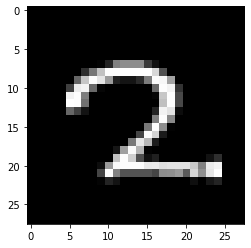

In [45]:
z = x_test[77]
print(test(z))
plt.imshow(z, cmap="gray")

# Accuracy for train and test:

In [46]:
y_preds_train=test_batch(x_train)
corrects=0
for i in range(len(x_train)):
  corrects+=int(y_preds_train[i]==y_train[i])
train_acc=corrects/len(x_train) * 100
print(f"train accuracy: {train_acc:.2f}%")

  0%|          | 0/10 [00:00<?, ?it/s]

train accuracy: 97.27%


In [47]:
y_preds_test=test_batch(x_test)
corrects=0
for i in range(len(x_test)):
  corrects+=int(y_preds_test[i]==y_test[i])
test_acc=corrects/len(x_test) * 100
print(f"test accuracy: {test_acc:.2f}%")

  0%|          | 0/10 [00:00<?, ?it/s]

test accuracy: 96.26%
